In [1]:
# system
import sys
sys.path.append("../../Kaggle-Ensemble-Guide-master/")

# Data Handling
import pandas as pd
import numpy as np
import math
import scipy.stats as sps
#from scipy import stats, integrate
from time import time


# sklearn and models
from sklearn import preprocessing, ensemble, metrics, feature_selection, model_selection, pipeline
import xgboost as xgb

#plotting and display
from IPython.display import display
from matplotlib import pyplot
import pprint
%pylab inline

C:\Users\Andrew\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Populating the interactive namespace from numpy and matplotlib


In [2]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [3]:
# set up pickle functions for saving and restoring tuned classifier
import pickle

def dump_pkl(my_object, filename):
    with open(filename, "w") as outfile:
        pickle.dump(my_object, outfile)


def load_pkl(filename):
    with open(filename, "r") as infile:
        obj = pickle.load(infile)
        return obj

### Load Data

In [4]:
# create date parser
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

# create data type converters
dtype_map_weather = dict(Station = 'str')
dtype_map_test_train = dict(Block = 'str', Street = 'str')

# read data into PANDAS DataFrames with date parsing
test = pd.read_csv('input/test.csv', parse_dates=['Date'], date_parser=dateparse, dtype= dtype_map_test_train)
train = pd.read_csv('input/train.csv', parse_dates=['Date'], date_parser=dateparse, dtype= dtype_map_test_train)
weather = pd.read_csv('input/weather.csv', parse_dates=['Date'], date_parser=dateparse, dtype= dtype_map_weather)
sample_sub = pd.read_csv('input/sampleSubmission.csv')

In [5]:
print('Train')
display(train.info())

print('Test')
display(test.info())

Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null object
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 985.0+ KB


None

Test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null datetime64[ns]
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null object
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 9.8+ MB


None

In [6]:
print('Weather')
display(weather.info())

Weather
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null object
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(16)
memory usage: 506.1+ KB


None

### Select Columns

In [7]:
# weather
weather_exclude = ['Dewpoint', 'WetBulb', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'StnPressure',
                 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed','DewPoint']
weather_cols = [col for col in weather.columns if col not in weather_exclude]
weather = weather[weather_cols]


# train
train_exclude = ['Address', 'AddressNumberAndStreet', 'AddressAccuracy', 'NumMosquitos']
train_cols = [col for col in train.columns if col not in train_exclude]
train = train[train_cols]

# test
test_exclude = ['Address', 'AddressNumberAndStreet', 'AddressAccuracy', 'Id']
test_cols = [col for col in test.columns if col not in test_exclude]
test = test[test_cols]

In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 11 columns):
Station        2944 non-null object
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
PrecipTotal    2944 non-null object
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 253.1+ KB


In [9]:
print('Weather')
display(weather.head())

print('Train')
display(train.head())

Weather


,Station,Date,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
0,1,2007-05-01,83,50,67,14,0,2,0448,1849,0.00
1,2,2007-05-01,84,52,68,M,0,3,-,-,0.00
2,1,2007-05-02,59,42,51,-3,14,0,0447,1850,0.00
3,2,2007-05-02,60,43,52,M,13,0,-,-,0.00
4,1,2007-05-03,66,46,56,2,9,0,0446,1851,0.00


Train


,Date,Species,Block,Street,Trap,Latitude,Longitude,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,0
2,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0
4,2007-05-29,CULEX RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,0


In [10]:
# what species have been detected (note that according to the CDC each
# of these species can carry WNV)
set(train.Species)

{'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS'}

In [11]:
# does this correspond to the test set
set(test.Species)
# it looks like there is another category

{'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS',
 'UNSPECIFIED CULEX'}

In [12]:
train.groupby('Species').sum().WnvPresent

Species
CULEX ERRATICUS             0
CULEX PIPIENS             240
CULEX PIPIENS/RESTUANS    262
CULEX RESTUANS             49
CULEX SALINARIUS            0
CULEX TARSALIS              0
CULEX TERRITANS             0
Name: WnvPresent, dtype: int64

### Examine and Handle missing Data

**What is 'T' and 'M'?**
- From http://www.nws.noaa.gov/om/csd/info/NOWdata/FAQ.php

> "M" stands for "Missing". Data for an element will be missing if the primary sensor for that weather element is inoperable (e.g., has an outage) or malfunctioning (e.g., producing errant data) AND any collocated backup sensor is also inoperable or malfunctioning. "T" stand for "Trace". This is a small amount of precipitation that will wet a raingage but is less than the 0.01 inch measuring limit.

The Precipitation Total column is the only column in the retained data that can contain this value. The value has leading whitespace so we should strip prior to counting.

In [13]:
# strip whitespace
weather.PrecipTotal = weather.PrecipTotal.str.strip()

In [14]:
miss_weather = ['M', '-']
trace_weather = ['T']

In [15]:
cols_not_date = [col for col in weather.columns if col != 'Date']

In [16]:
weather[cols_not_date].apply(pd.value_counts, axis=1)[miss_weather + trace_weather].fillna(0).sum()

M    1507.0
-    2944.0
T     318.0
dtype: float64

In [17]:
# Both stations
check = weather[cols_not_date].apply(pd.value_counts, axis=0).fillna(0)
check.loc[['M', '-', 'T']]

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,0.0,0.0,0.0,11.0,1472.0,11.0,11.0,0.0,0.0,2.0
-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1472.0,1472.0,0.0
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318.0


In [18]:
# Station 1
check_stat1 = weather[cols_not_date][weather.Station == '1'].apply(pd.value_counts, axis=0).fillna(0)
check_stat1.loc[['M', '-', 'T']]

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0


In [19]:
# Station 2
check_stat2 = weather[cols_not_date][weather.Station == '2'].apply(pd.value_counts, axis=0).fillna(0)
check_stat2.loc[['M', '-', 'T']]

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,0.0,0.0,0.0,11.0,1472.0,11.0,11.0,0.0,0.0,2.0
-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1472.0,1472.0,0.0
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0


In [20]:
# Both stations
check.loc[['M', '-', 'T']]/(len(weather)) * 100

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,0.0,0.0,0.0,0.373641,50.0,0.373641,0.373641,0.0,0.0,0.067935
-,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,50.0,50.0,0.000000
T,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,10.801630


In [21]:
# Station 1
check_stat1.loc[['M', '-', 'T']]/(len(weather)) * 100

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.536685


In [22]:
# Station 2()
check_stat2.loc[['M', '-', 'T']]/(len(weather)) * 100

,Station,Tmax,Tmin,Tavg,Depart,Heat,Cool,Sunrise,Sunset,PrecipTotal
M,0.0,0.0,0.0,0.373641,50.0,0.373641,0.373641,0.0,0.0,0.067935
-,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,50.0,50.0,0.000000
T,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,5.264946


In [23]:
# reaplace M and - with NaN, impute T
weather = weather.replace('M', np.NaN)
weather = weather.replace('-', np.NaN)
weather = weather.replace('T', 0.005) # very small amounts of rain can impact mosquito hatches

# forward fill missing station 2 data with station 1 data
weather.Tmax = weather.Tmax.fillna(method = 'ffill')
weather.Tmin = weather.Tmin.fillna(method = 'ffill')
weather.Depart = weather.Depart.fillna(method = 'ffill')
weather.Heat = weather.Heat.fillna(method = 'ffill')
weather.Cool = weather.Cool.fillna(method = 'ffill')
weather.PrecipTotal = weather.PrecipTotal.fillna(method = 'ffill')

In [24]:
# convert datatpypes

to_numeric = ['Tmax','Tmin','Tavg', 'Depart', 'Heat', 'Cool', 'PrecipTotal']

for col in to_numeric:
    weather[col]= pd.to_numeric(weather[col])

In [25]:
# forward fill station 2 sunrise and sunset data with station 1 data
weather.Sunrise = weather.Sunrise.fillna(method = 'ffill')
weather.Sunset = weather.Sunset.fillna(method = 'ffill')

In [26]:
# sunset has entries where instead of incrementing to the next hour after xx59 it incremented to xx60
# This causes an exception, let's take a look
counter = 0
tracker = []
for index, val in enumerate(weather.Sunset):
    try:
        pd.to_datetime(val, format = '%H%M').time()
    except:
        counter += 1
        tracker.append((index, val, val[2:], counter))

print(tracker[-1])

# there are 48 exceptions

(2925, '1660', '60', 48)


In [27]:
# let's deal with this by decrmenting by 1 for each invalid instance
weather.Sunset = weather.Sunset.replace('\+?60', '59', regex = True)

# time conversion lambda function
time_func = lambda x: pd.Timestamp(pd.to_datetime(x, format = '%H%M'))

weather.Sunrise = weather.Sunrise.apply(time_func)

weather.Sunset = weather.Sunset.apply(time_func)

In [28]:
# what is the range of values for sunrise and sunset (in hours)
minutes= (weather.Sunset - weather.Sunrise).astype('timedelta64[m]')

hours = minutes/60

In [29]:
set(np.round(hours.values))

{10.0, 11.0, 12.0, 13.0, 14.0, 15.0}

In [30]:
#create a DayLength column with minute level precsion
weather['DayLength_MPrec'] = (weather.Sunset - weather.Sunrise).astype('timedelta64[m]')/60

#create a DayLength column with rounded to the nearest hour
weather['DayLength_NearH'] = np.round(((weather.Sunset - weather.Sunrise).astype('timedelta64[m]')/60).values)

# length of night with minute level precision
weather['NightLength_MPrec']= 24.0 - weather.DayLength_MPrec

# length of night rounded to nearest hour
weather['NightLength_NearH']= 24.0 - weather.DayLength_NearH

In [31]:
# function to calculate sunset and sunrise times in hours
hours_RiseSet_func = lambda x: x.minute/60.0 + float(x.hour)

# sunrise in hours
weather['Sunrise_hours'] = weather.Sunrise.apply(hours_RiseSet_func)

# sunset in hours
weather['Sunset_hours'] = weather.Sunset.apply(hours_RiseSet_func)

In [32]:
# create columns that blend (use the mean) of station 1 and 2 values
mean_func = lambda x: x.mean()

blend_cols = ['Tmax', 'Tmin', 'Depart' ,'Heat', 'Cool', 'PrecipTotal']

blended_cols= ['blended_' + col for col in blend_cols]

# split
station_1 = weather[blend_cols][weather.Station == '1']
station_2 = weather[blend_cols][weather.Station == '2']

station_blend = pd.DataFrame((station_1.values + station_2.values)/2, columns= blended_cols)

# apply
extract_2 = weather[weather.Station == '2'].reset_index(drop = True)
extract_1 = weather[weather.Station == '1'].reset_index(drop = True)



# combine
joined_1 = extract_1.join(station_blend)
joined_2 = extract_2.join(station_blend)

weather_blend = pd.concat([joined_1, joined_2])

In [33]:
weather_blend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 1471
Data columns (total 23 columns):
Station                2944 non-null object
Date                   2944 non-null datetime64[ns]
Tmax                   2944 non-null int64
Tmin                   2944 non-null int64
Tavg                   2933 non-null float64
Depart                 2944 non-null int64
Heat                   2944 non-null int64
Cool                   2944 non-null int64
Sunrise                2944 non-null datetime64[ns]
Sunset                 2944 non-null datetime64[ns]
PrecipTotal            2944 non-null float64
DayLength_MPrec        2944 non-null float64
DayLength_NearH        2944 non-null float64
NightLength_MPrec      2944 non-null float64
NightLength_NearH      2944 non-null float64
Sunrise_hours          2944 non-null float64
Sunset_hours           2944 non-null float64
blended_Tmax           2944 non-null float64
blended_Tmin           2944 non-null float64
blended_Depart         2944 

### Create Month and Day columns

In [34]:
month_func = lambda x: x.month
day_func= lambda x: x.day
day_of_year_func = lambda x: x.dayofyear
week_of_year_func = lambda x: x.week

# train
train['month'] = train.Date.apply(month_func)
train['day'] = train.Date.apply(day_func)
train['day_of_year'] = train.Date.apply(day_of_year_func)
train['week'] = train.Date.apply(week_of_year_func)

# test
test['month'] = test.Date.apply(month_func)
test['day'] = test.Date.apply(day_func)
test['day_of_year'] = test.Date.apply(day_of_year_func)
test['week'] = test.Date.apply(week_of_year_func)

In [35]:
train.describe()

,Latitude,Longitude,WnvPresent,month,day,day_of_year,week
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,41.841139,-87.699908,0.052446,7.692557,15.341424,217.941938,31.687131
std,0.112742,0.096514,0.222936,1.067675,8.901205,31.735797,4.526874
min,41.644612,-87.930995,0.000000,5.000000,1.000000,148.000000,22.000000
25%,41.732984,-87.760070,0.000000,7.000000,7.000000,196.000000,28.000000
50%,41.846283,-87.694991,0.000000,8.000000,15.000000,217.000000,31.000000
75%,41.954690,-87.627796,0.000000,8.000000,24.000000,241.000000,35.000000
max,42.017430,-87.531635,1.000000,10.000000,31.000000,282.000000,41.000000


In [36]:
test.describe()

,Latitude,Longitude,month,day,day_of_year,week
count,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000
mean,41.849389,-87.693658,7.620244,16.187681,217.057304,31.417833
std,0.106593,0.080699,1.065842,8.800007,32.536523,4.660725
min,41.644612,-87.930995,6.000000,1.000000,153.000000,22.000000
25%,41.753411,-87.750938,7.000000,10.000000,193.000000,28.000000
50%,41.862292,-87.694991,8.000000,17.000000,217.000000,31.000000
75%,41.951866,-87.648860,8.000000,24.000000,244.000000,35.000000
max,42.017430,-87.531635,10.000000,31.000000,275.000000,40.000000


In [37]:
# remove sunrise and sunset since we have extracted critical information into other fields
weather_blend = weather_blend.drop(['Sunrise', 'Sunset'], axis= 1)

### Merge Data

In [38]:
train = train.merge(weather_blend, on='Date')
test = test.merge(weather_blend, on='Date')

### Inspect DFs

In [39]:
weather_blend.ix[:,:12].describe()

C:\Users\Andrew\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Tmax,Tmin,Tavg,Depart,Heat,Cool,PrecipTotal,DayLength_MPrec,DayLength_NearH,NightLength_MPrec
count,2944.000000,2944.000000,2933.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,76.166101,57.810462,67.240027,1.954484,3.417799,5.641304,0.131780,13.669384,13.646739,10.330616
std,11.461970,10.381939,10.545442,6.839947,5.955153,6.104849,0.393031,1.489822,1.485758,1.489822
min,41.000000,29.000000,36.000000,-17.000000,0.000000,0.000000,0.000000,10.400000,10.000000,8.766667
25%,69.000000,50.000000,NaN,-3.000000,0.000000,0.000000,0.000000,12.512500,12.750000,9.045833
50%,78.000000,59.000000,NaN,2.000000,0.000000,4.000000,0.000000,14.233333,14.000000,9.766667
75%,85.000000,66.000000,NaN,7.000000,5.000000,10.000000,0.060000,14.954167,15.000000,11.487500
max,104.000000,83.000000,94.000000,23.000000,29.000000,29.000000,6.860000,15.233333,15.000000,13.600000


In [40]:
weather_blend.ix[:,12:].describe()

,NightLength_NearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_Depart,blended_Heat,blended_Cool,blended_PrecipTotal
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.00000
mean,10.353261,4.992663,18.662047,76.166101,57.810462,1.954484,3.417799,5.641304,0.13178
std,1.485758,0.651771,0.843787,11.422764,10.268370,6.839947,5.932802,6.061981,0.35829
min,9.000000,4.266667,16.783333,41.500000,29.000000,-17.000000,0.000000,0.000000,0.00000
25%,9.000000,4.412500,18.033333,68.500000,50.500000,-3.000000,0.000000,0.000000,0.00000
50%,10.000000,4.775000,18.983333,78.500000,59.500000,2.000000,0.000000,4.000000,0.00250
75%,11.250000,5.520833,19.370833,84.500000,65.500000,7.000000,4.500000,10.500000,0.08000
max,14.000000,6.383333,19.516667,103.500000,82.500000,23.000000,29.000000,28.500000,4.85500


In [41]:
train.describe()

,Latitude,Longitude,WnvPresent,month,day,day_of_year,week,Tmax,Tmin,Tavg,...,NightLength_MPrec,NightLength_NearH,Sunrise_hours,Sunset_hours,blended_Tmax,blended_Tmin,blended_Depart,blended_Heat,blended_Cool,blended_PrecipTotal
count,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,...,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000,21012.000000
mean,41.841139,-87.699908,0.052446,7.692557,15.341424,217.941938,31.687131,81.917095,63.647202,73.022463,...,9.993359,10.031696,4.890621,18.897262,81.917095,63.647202,2.740244,0.886208,8.908671,0.146082
std,0.112739,0.096512,0.222930,1.067649,8.900993,31.735042,4.526766,8.290251,7.593949,7.501455,...,1.048358,1.047465,0.463813,0.589987,8.272521,7.486933,6.486313,2.697339,5.712594,0.323131
min,41.644612,-87.930995,0.000000,5.000000,1.000000,148.000000,22.000000,57.000000,41.000000,50.000000,...,8.766667,9.000000,4.266667,17.333333,57.500000,42.500000,-12.000000,0.000000,0.000000,0.000000
25%,41.732984,-87.760070,0.000000,7.000000,7.000000,196.000000,28.000000,78.000000,59.000000,70.000000,...,9.050000,9.000000,4.483333,18.533333,78.000000,59.500000,-2.000000,0.000000,5.000000,0.000000
50%,41.846283,-87.694991,0.000000,8.000000,15.000000,217.000000,31.000000,83.000000,65.000000,75.000000,...,9.700000,10.000000,4.816667,19.116667,83.000000,65.500000,4.000000,0.000000,9.500000,0.000000
75%,41.954690,-87.627796,0.000000,8.000000,24.000000,241.000000,35.000000,88.000000,69.000000,79.000000,...,10.700000,11.000000,5.233333,19.400000,88.000000,69.500000,8.000000,0.000000,13.500000,0.130000
max,42.017430,-87.531635,1.000000,10.000000,31.000000,282.000000,41.000000,97.000000,79.000000,87.000000,...,12.616667,13.000000,5.950000,19.516667,96.500000,77.500000,18.000000,14.000000,20.500000,2.420000


### Handle Weather Stations 1

In [42]:
# columns to write
cols_to_write = [col for col in train.columns if col != 'Date'] # exclude 'Date'

# split the data into two dataframes by station

train_station_1= train[train.Station == '1']
train_station_2= train[train.Station == '2']

test_station_1= test[test.Station == '1']
test_station_2= test[test.Station == '2']

# epxort to csv for external use
train_station_1.to_csv('train_station_1.csv')
train_station_2.to_csv('train_station_2.csv')
train.to_csv('train.csv')

# Prepare Data Set for Model Building

In [43]:
# set up a merge for stations 1 and 2
# keep unique cols from station 2
keep_cols = ['Date', u'Tmax', u'Tmin', u'Tavg',u'PrecipTotal']
train_station_2 = train_station_2[keep_cols]
test_station_2 = test_station_2[keep_cols]

# rename cols with prefix
prefix_s2 = 'stat_2_'
rename_cols_s2 = [prefix_s2 + col for col in train_station_2.columns]
train_station_2.columns = rename_cols_s2
test_station_2.columns = rename_cols_s2

# drop cols from station 1 that won't be used in model
drop_cols = ['Heat', 'Cool', 'Depart', 'NightLength_MPrec', 'NightLength_NearH',
            'blended_Depart', 'blended_Heat', 'blended_Cool']

train_station_1 = train_station_1.drop(drop_cols, axis= 1)
test_station_1 = test_station_1.drop(drop_cols, axis= 1)   

# raname uniqe station 1 columns
prefix_s1 = 'stat_1_'
rename_cols_s1 = [prefix_s1 + col for col in keep_cols]
cols_to_rename= [col for col in train_station_1.columns if col in keep_cols]

# setup name mapping
s1_name_map = dict(zip(cols_to_rename, rename_cols_s1))

train_station_1 = train_station_1.rename(columns= s1_name_map)
test_station_1 = test_station_1.rename(columns= s1_name_map)

# concat (outer join)
train_station_1 =  train_station_1.reset_index(drop= True)
train_station_2 = train_station_2.reset_index(drop = True)
train_merge = pd.concat([train_station_1, train_station_2], axis= 1)

test_station_1 =  test_station_1.reset_index(drop= True)
test_station_2 = test_station_2.reset_index(drop = True)
test_merge = pd.concat([test_station_1, test_station_2], axis= 1)

### Create Dummies from Categorical Variables

In [44]:
train_merge.columns

Index([        u'stat_1_Date',             u'Species',               u'Block',
                    u'Street',                u'Trap',            u'Latitude',
                 u'Longitude',          u'WnvPresent',               u'month',
                       u'day',         u'day_of_year',                u'week',
                   u'Station',         u'stat_1_Tmax',         u'stat_1_Tmin',
               u'stat_1_Tavg',  u'stat_1_PrecipTotal',     u'DayLength_MPrec',
           u'DayLength_NearH',       u'Sunrise_hours',        u'Sunset_hours',
              u'blended_Tmax',        u'blended_Tmin', u'blended_PrecipTotal',
               u'stat_2_Date',         u'stat_2_Tmax',         u'stat_2_Tmin',
               u'stat_2_Tavg',  u'stat_2_PrecipTotal'],
      dtype='object')

In [45]:
test_merge.columns

Index([        u'stat_1_Date',             u'Species',               u'Block',
                    u'Street',                u'Trap',            u'Latitude',
                 u'Longitude',               u'month',                 u'day',
               u'day_of_year',                u'week',             u'Station',
               u'stat_1_Tmax',         u'stat_1_Tmin',         u'stat_1_Tavg',
        u'stat_1_PrecipTotal',     u'DayLength_MPrec',     u'DayLength_NearH',
             u'Sunrise_hours',        u'Sunset_hours',        u'blended_Tmax',
              u'blended_Tmin', u'blended_PrecipTotal',         u'stat_2_Date',
               u'stat_2_Tmax',         u'stat_2_Tmin',         u'stat_2_Tavg',
        u'stat_2_PrecipTotal'],
      dtype='object')

In [46]:
# get label
labels = train_merge.pop('WnvPresent').values

# remove dates
train_merge = train_merge.drop(['stat_1_Date', 'stat_2_Date'], axis = 1)

test_merge = test_merge.drop(['stat_1_Date', 'stat_2_Date' ], axis = 1)

# Create dummies from the categorical species, block, trap, and streetname
train_merge = pd.get_dummies(train_merge, columns= ['Species'])
train_merge = pd.get_dummies(train_merge, columns= ['Block'])
train_merge = pd.get_dummies(train_merge, columns= ['Street'])
train_merge = pd.get_dummies(train_merge, columns= ['Trap'])

test_merge = pd.get_dummies(test_merge, columns= ['Species'])
test_merge = pd.get_dummies(test_merge, columns= ['Block'])
test_merge = pd.get_dummies(test_merge, columns= ['Street'])
test_merge = pd.get_dummies(test_merge, columns= ['Trap'])

#train_merge= train_merge.drop(['Street', 'Trap', 'Station'], axis= 1)
#test_merge= test_merge.drop(['Street', 'Trap', 'Station'], axis= 1)

train_merge= train_merge.drop('Station', axis= 1)
test_merge= test_merge.drop('Station', axis= 1)

In [47]:
#drops= ['Block', 'Street', 'Trap', 'Latitude', 'Longitude']

#train_merge= train_merge.drop(drops, axis= 1)
#test_merge= test_merge.drop(drops, axis= 1)

In [48]:
len(train_merge.columns)

356

In [49]:
len(test_merge.columns)

382

In [50]:
# we have a discrepancy so let's remove columns in the test set we have not information for
unique_test_cols = [col for col in test_merge.columns if col not in train_merge.columns]

test_merge= test_merge.drop(unique_test_cols, axis= 1)

### Build some initial Models

In [51]:
# build a random forest model similiar to that used to beat benchmark in competition
clf = ensemble.RandomForestClassifier(n_estimators=1000, min_samples_split= 2, random_state= 42)
clf.fit(train_merge, labels)

# create predictions and submission file
predictions_randfor = clf.predict_proba(test_merge)[:,1]

#### Outcome
- AUC for Random forest models on private test data (private leaderboard) tends to fall in the range of 0.655 and of 0.687

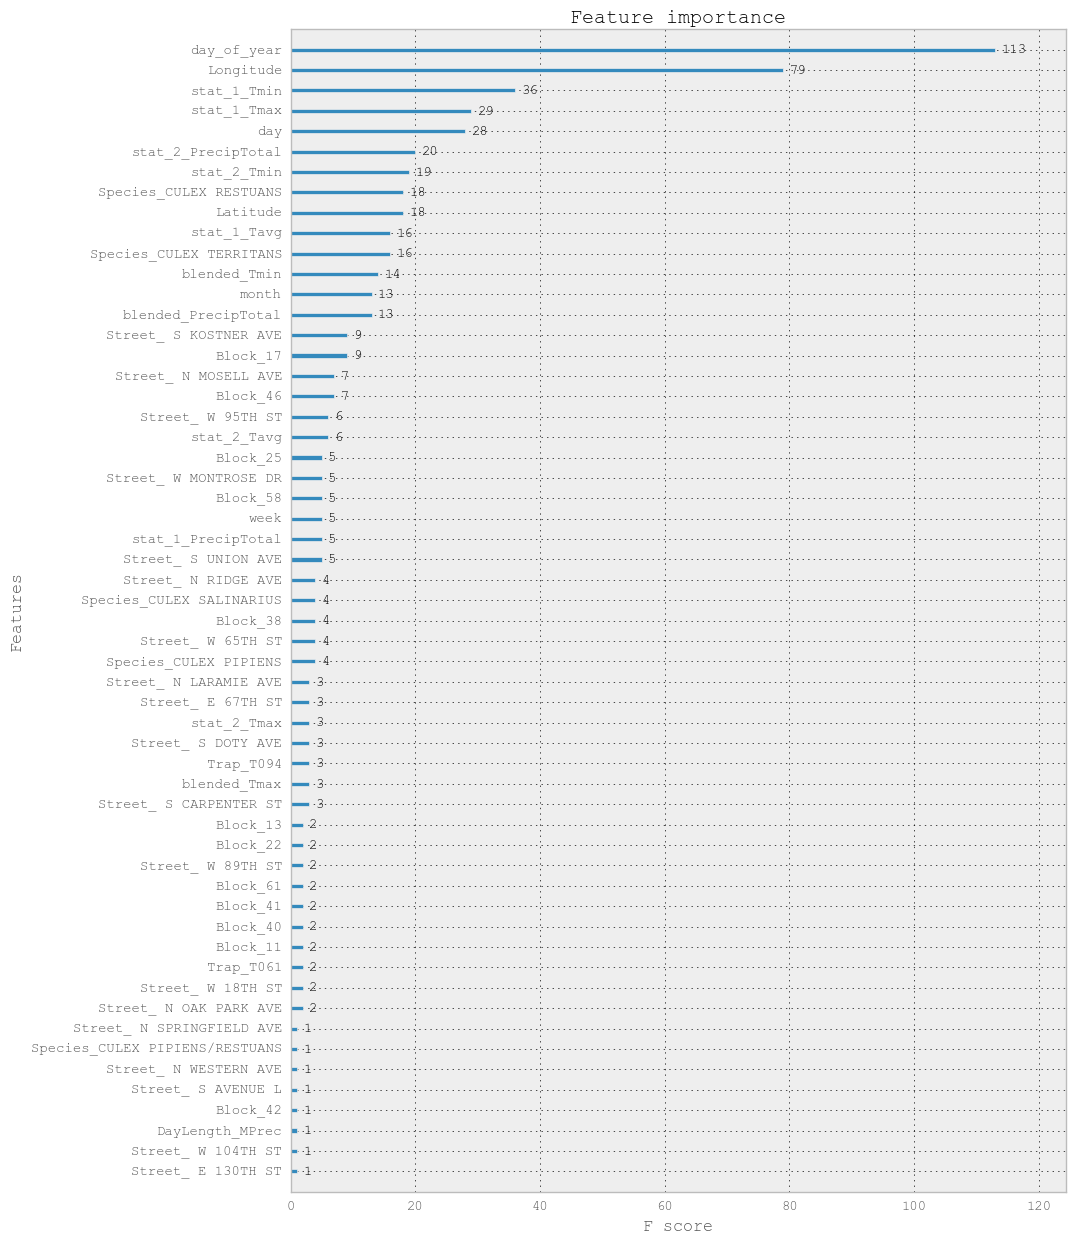

In [52]:
# fit model no training data
xgbc = xgb.XGBClassifier(seed= 42)
xgbc.fit(train_merge, labels)
# feature importance
#print(xgb.feature_importances_)

# plot feature importance with xgb class method
fig, ax = pyplot.subplots(figsize=(10, 15))
xgb.plot_importance(xgbc, ax=ax)

## Sandbox Setup validation set from training set

In [53]:
def calc_roc_auc(y, predict_probs):
    
    """
    Function accepts labels (matrix y) and predicted probabilities
    Function calculates fpr (false positive rate), tpr (true postivies rate), thresholds and auc (area under
    the roc curve)
    Function returns auc
    """
    fpr, tpr, thresholds = metrics.roc_curve(y, predict_probs)
    roc_auc = metrics.auc(fpr, tpr)
    
    return roc_auc

In [54]:

train_split, val_split, label_train_split, label_val_split = model_selection.train_test_split(train_merge, 
                                      labels, test_size = 0.33, random_state = 42, stratify= labels)

In [55]:
def select_features_by_importance_threshold(model, X_train, y_train, selection_model, X_test, y_test,
                                           minimum = False):
    
    """
    Function accepts model and data dn breaksdow performance (AUC) by threshold and n-features
    """

    # Fit model using each importance as a threshold
    if minimum:
        thresholds= np.unique(model.feature_importances_[model.feature_importances_ > minimum])
        # include 0 for all features
        thresholds = np.insert(thresholds, 0, 0.)
    else:
        thresholds= np.unique(model.feature_importances_)
        
    
    print(thresholds)
    for thresh in thresholds:
	    # select features using threshold
        selection = feature_selection.SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = selection_model
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict_proba(select_X_test)[:,1]
        predictions = y_pred
        #predictions = [round(value) for value in y_pred]
        auc = calc_roc_auc(y_test, predictions)
        print("Thresh=%.3f, n=%d, AUC: %.2f%%" % (thresh, select_X_train.shape[1], auc))

In [56]:
select_features_by_importance_threshold(xgbc, train_split, label_train_split,
                                       xgb.XGBClassifier(seed= 42), val_split, label_val_split)

[ 0.          0.00173913  0.00347826  0.00521739  0.00695652  0.00869565
  0.01043478  0.01217391  0.01565217  0.0226087   0.02434783  0.02782609
  0.03130435  0.03304348  0.03478261  0.04869565  0.05043478  0.0626087
  0.1373913   0.19652174]
Thresh=0.000, n=356, AUC: 0.83%
Thresh=0.002, n=56, AUC: 0.83%
Thresh=0.003, n=48, AUC: 0.83%
Thresh=0.005, n=38, AUC: 0.83%
Thresh=0.007, n=31, AUC: 0.83%
Thresh=0.009, n=26, AUC: 0.83%
Thresh=0.010, n=20, AUC: 0.83%
Thresh=0.012, n=18, AUC: 0.83%
Thresh=0.016, n=16, AUC: 0.83%
Thresh=0.023, n=14, AUC: 0.83%
Thresh=0.024, n=12, AUC: 0.83%
Thresh=0.028, n=11, AUC: 0.83%
Thresh=0.031, n=9, AUC: 0.82%
Thresh=0.033, n=7, AUC: 0.82%
Thresh=0.035, n=6, AUC: 0.82%
Thresh=0.049, n=5, AUC: 0.82%
Thresh=0.050, n=4, AUC: 0.82%
Thresh=0.063, n=3, AUC: 0.81%
Thresh=0.137, n=2, AUC: 0.80%
Thresh=0.197, n=1, AUC: 0.78%


It appears that most of the AUC is covered by the top 10 - 12 features.  

In [57]:
select_features_by_importance_threshold(clf, train_split, label_train_split,
                                       ensemble.RandomForestClassifier(random_state= 42), val_split, 
                                        label_val_split, minimum= 3.0e-3 )

[ 0.          0.00300846  0.00301136  0.00301776  0.00302547  0.00303388
  0.0030579   0.00313569  0.00315084  0.00315972  0.00317738  0.0031777
  0.00320936  0.00322403  0.00323428  0.00327353  0.00333787  0.00337582
  0.00342431  0.00350448  0.00355606  0.00372441  0.00383991  0.00386383
  0.00391088  0.00400462  0.00410406  0.00411903  0.00448199  0.00491754
  0.00545869  0.00565519  0.00589606  0.00871788  0.0099078   0.01002871
  0.01133463  0.01138912  0.01684412  0.0168731   0.01692397  0.01706072
  0.01726514  0.01736102  0.01828223  0.01836379  0.01842711  0.01845862
  0.02351926  0.02366896  0.02378099  0.02449534  0.03455466  0.0413841
  0.04772961  0.06465314  0.07361844]
Thresh=0.000, n=356, AUC: 0.72%
Thresh=0.003, n=56, AUC: 0.71%
Thresh=0.003, n=55, AUC: 0.71%
Thresh=0.003, n=54, AUC: 0.72%
Thresh=0.003, n=53, AUC: 0.71%
Thresh=0.003, n=52, AUC: 0.71%
Thresh=0.003, n=51, AUC: 0.72%
Thresh=0.003, n=50, AUC: 0.72%
Thresh=0.003, n=49, AUC: 0.73%
Thresh=0.003, n=48, AUC: 0.

It appears that most of the AUC is covered by he top 10ish features

### Use Select From Model to transform data by threshold

In [58]:
# Set a minimum threshold of 0.023
sfm = feature_selection.SelectFromModel(xgbc, threshold=0.023, prefit= True)
sfm_train= sfm.transform(train_merge)
n_features = sfm_train.shape[1]
print(n_features)

12


In [60]:
# initialize and fit model
xgb_clf= xgb.XGBClassifier(seed= 42)
xgb_clf.fit(sfm_train, labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [61]:
# transform test set and predict
sfm_test = sfm.transform(test_merge)
predictions_xgb = xgb_clf.predict_proba(sfm_test)[:,1]
predictions_randfor= clf.predict_proba(test_merge)[:,1]

In [63]:
sample_sub['WnvPresent'] = predictions_randfor
sample_sub.to_csv('sub_randfor.csv', index=False)

### Address overfittting through early stopping

In [64]:
# split into training and validation sets
X_train= train_split
X_test= val_split
y_train= label_train_split
y_test= label_val_split

# instantiate base model
model= xgb.XGBClassifier(seed= 42)

# setup eval
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose= True)

results = model.evals_result()
#pprint.pprint(results)

[0]	validation_0-auc:0.789671	validation_1-auc:0.758943
[1]	validation_0-auc:0.797245	validation_1-auc:0.773398
[2]	validation_0-auc:0.803481	validation_1-auc:0.787082
[3]	validation_0-auc:0.803651	validation_1-auc:0.785039
[4]	validation_0-auc:0.812916	validation_1-auc:0.784324
[5]	validation_0-auc:0.813058	validation_1-auc:0.785745
[6]	validation_0-auc:0.81538	validation_1-auc:0.785033
[7]	validation_0-auc:0.817277	validation_1-auc:0.789943
[8]	validation_0-auc:0.817461	validation_1-auc:0.78944
[9]	validation_0-auc:0.813191	validation_1-auc:0.790056
[10]	validation_0-auc:0.824453	validation_1-auc:0.800585
[11]	validation_0-auc:0.827806	validation_1-auc:0.805505
[12]	validation_0-auc:0.829073	validation_1-auc:0.807693
[13]	validation_0-auc:0.828366	validation_1-auc:0.807228
[14]	validation_0-auc:0.830464	validation_1-auc:0.807532
[15]	validation_0-auc:0.834266	validation_1-auc:0.803445
[16]	validation_0-auc:0.834383	validation_1-auc:0.804325
[17]	validation_0-auc:0.83592	validation_1-

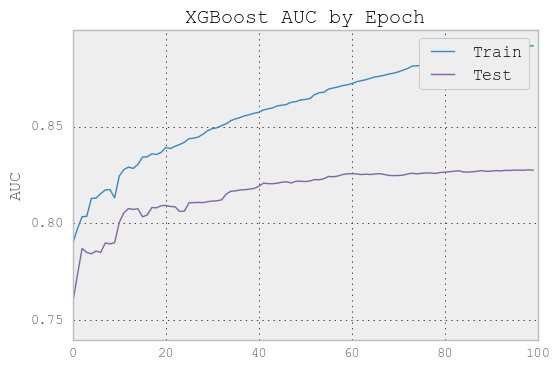

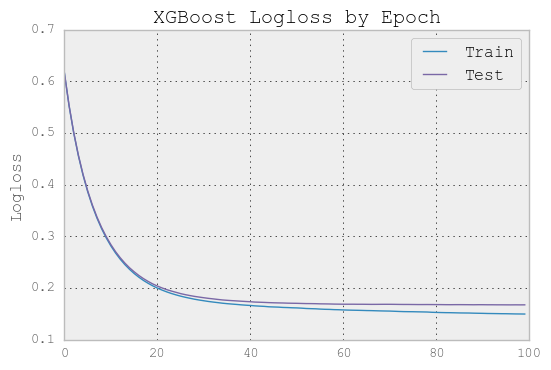

In [65]:
model.fit(X_train, y_train, eval_metric=["auc", "logloss", "error"], eval_set=eval_set, verbose= False)
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot auc
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC by Epoch')
pyplot.show()

# plot logloss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Logloss')
pyplot.title('XGBoost Logloss by Epoch')
pyplot.show()

It looks like we get into overfiting within 20ish epochs

In [66]:
# train a model with eartly stopping
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["auc"], eval_set=eval_set, early_stopping_rounds=10, verbose= False)

#results = model.evals_result()
#print(results)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

### Models in A minor (tuning...)

In [67]:
# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [68]:
# Set a minimum threshold of 0.023
sfm = feature_selection.SelectFromModel(xgbc, threshold=0.015, prefit= True)
sfm_train= sfm.transform(train_split)
n_features = sfm_train.shape[1]
print(n_features)

sfm_test= sfm.transform(val_split)

sfm_test_merge= sfm.transform(test_merge)

sfm_train_merge= sfm.transform(train_merge)

16


In [69]:
# instantiate base model
model= xgb.XGBClassifier(seed= 42)

In [70]:
# setup distributions for random search, left some notes

#n_estimators_dist= np.random.randint(1, 500)# number of trees, could use a discrete list or np.random.exponential(scale=0.1, size= 100)
#colsample_bytree_dist= np.random.uniform(0.2,0.6) # should be 0.3 - 0.5
#max_depth_dist = np.random.randint(2, 12) # typical values 3 - 10
#learning_rate_dist= np.random.uniform(0.01, 0.3) # default 0.3, typical values 0.01 - 0.2

#learning_rate_dist= scipy.stats.expon(scale=100)
#learning_rate_dist= 10. ** np.arange(-3, -2)
n_estimators_dist= sps.randint(1, 300)
learning_rate_dist = [0.01, 0.02, 0.05, 0.1, .15, 0.2, .25, 0.3]
max_depth_dist = sps.randint(2, 12)
colsample_bytree_dist= np.arange(0.2, 0.6, .1)

In [71]:
X_train = sfm_train
y_train = label_train_split

In [72]:
cv = model_selection.StratifiedShuffleSplit(n_splits = 10, random_state = 42)  

param_dist = dict(learning_rate= learning_rate_dist, n_estimators= n_estimators_dist,
                 colsample_bytree= colsample_bytree_dist, max_depth= max_depth_dist) 

# run randomized search
n_iter_search = 20
random_search_xgb = model_selection.RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring= 'roc_auc', cv= cv)

start = time()
random_search_xgb.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search_xgb.cv_results_)

RandomizedSearchCV took 87.32 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.847 (std: 0.025)
Parameters: {'n_estimators': 255, 'learning_rate': 0.25, 'colsample_bytree': 0.30000000000000004, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.844 (std: 0.026)
Parameters: {'n_estimators': 215, 'learning_rate': 0.25, 'colsample_bytree': 0.20000000000000001, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.840 (std: 0.026)
Parameters: {'n_estimators': 247, 'learning_rate': 0.02, 'colsample_bytree': 0.40000000000000008, 'max_depth': 8}

Model with rank: 4
Mean validation score: 0.840 (std: 0.023)
Parameters: {'n_estimators': 179, 'learning_rate': 0.2, 'colsample_bytree': 0.30000000000000004, 'max_depth': 4}

Model with rank: 5
Mean validation score: 0.840 (std: 0.026)
Parameters: {'n_estimators': 145, 'learning_rate': 0.05, 'colsample_bytree': 0.40000000000000008, 'max_depth': 8}

Model with rank: 6
Mean validation score: 0.8

In [73]:
# best estimator
random_search_xgb.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.30000000000000004, gamma=0, learning_rate=0.25,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=255, nthread=-1, objective='binary:logistic',
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [74]:
# instantiate random forest mode
clf = ensemble.RandomForestClassifier(random_state= 42)

In [75]:
# setup best estimators
n_estimators_dist= sps.randint(1, 1000)

In [76]:
cv = model_selection.StratifiedShuffleSplit(n_splits = 10, random_state = 42)  

param_dist = {"max_depth": max_depth_dist,
              "max_features": sps.randint(1, n_features),
              "min_samples_split": sps.randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "n_estimators": n_estimators_dist} 

# run randomized search
n_iter_search = 20
random_search_randfor = model_selection.RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring= 'roc_auc')

start = time()
random_search_randfor.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report

RandomizedSearchCV took 201.47 seconds for 20 candidates parameter settings.


<function __main__.report>

In [77]:
(random_search_randfor.cv_results_)

{'mean_fit_time': array([ 1.46533338,  1.54833333,  6.55900002,  2.70666663,  3.16000001,
         0.70533323,  1.91166663,  2.25433326,  0.43733335,  2.41066662,
         0.80266666,  9.96033335,  5.0346667 ,  2.82566675,  0.92866667,
         1.15666668,  0.84333332,  2.47899993,  0.67866675,  3.43666665]),
 'mean_score_time': array([ 0.26399986,  0.18333332,  0.54733332,  0.42266679,  0.66566666,
         0.06566668,  0.39099995,  0.62366668,  0.06133334,  0.39099995,
         0.13033334,  0.79066666,  0.75933337,  0.35500002,  0.19833334,
         0.10800004,  0.10166669,  0.42000008,  0.10066668,  0.37233345]),
 'mean_test_score': array([ 0.82446215,  0.82939083,  0.80560513,  0.79062353,  0.81160264,
         0.81875953,  0.83221499,  0.8332224 ,  0.81192206,  0.81754177,
         0.83245018,  0.81976942,  0.80235298,  0.8100443 ,  0.83568336,
         0.79183375,  0.82074812,  0.79527055,  0.82917682,  0.78650353]),
 'mean_train_score': array([ 0.86792841,  0.96162126,  0.892763

In [78]:
# best estimator for randomforest
random_search_randfor.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=9, max_features=1,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=245, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [79]:
# dump model
dump_pkl(random_search_randfor.best_estimator_, 'randfor_best_est.pkl')

In [80]:
# load serialized model
best_randfor= load_pkl('randfor_best_est.pkl')
predictions_randfor = best_randfor.predict_proba(sfm_test)[:,1]
calc_roc_auc(label_val_split, predictions_randfor)

0.82339973572850289

In [81]:
# fit model on training data
best_randfor.fit(sfm_train_merge, labels)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=9, max_features=1,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=245, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [82]:
# make predictions with random forest model
preds_randfor= best_randfor.predict_proba(sfm_test_merge)[:,1]

In [83]:
# calculate AUC on validation set
best_xgb= random_search_xgb.best_estimator_

predictions_xgb= best_xgb.predict_proba(sfm_test)[:,1]
calc_roc_auc(label_val_split, predictions_xgb)

0.83049241473899005

In [84]:
predictions_xgb= best_xgb.predict_proba(sfm_test_merge)[:,1]

In [86]:
sample_sub['WnvPresent'] = predictions_xgb
sample_sub.to_csv('sub_xgb.csv', index=False)

In [85]:
# convert training data to xgb native format
xgdmat = xgb.DMatrix(sfm_train_merge, labels)

In [86]:
# train xgb classifier on all dat with built-in cv method and early stopping
cv_xgb = xgb.cv(params = best_xgb.get_params(), dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['auc'], early_stopping_rounds = 10,)

In [87]:
# how many rounds
len(cv_xgb)

88

In [88]:
# train with best params over established rounds
final_xgb= xgb.train(best_xgb.get_params(), xgdmat, num_boost_round = len(cv_xgb))

In [89]:
# dump xgb model
final_xgb.dump_model('final_xgb')

In [90]:
# transform test data to feature set
final_test= xgb.DMatrix(sfm_test_merge)

In [91]:
# make predicions
preds_xgb= final_xgb.predict(final_test) # logistic regression probs

In [ ]:
# create submissions
# Kaggle private leaderboard 0.74946
sample_sub['WnvPresent'] = preds_xgb
sample_sub.to_csv('sub_xgb.csv', index=False)

#sample_sub['WnvPresent'] = predictions_randfor
#sample_sub.to_csv('sub_randfor.csv', index=False)

# predictions.to_csv('predictions.csv', header= True, index_label= 'id')
# Kaggle Private Leaderboard 0.72141
sample_sub['WnvPresent'] = preds_randfor
sample_sub.to_csv('sub_randfor.csv', index=False)